<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 1</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">
Commit your solutions to our 
<a href='https://classroom.github.com/a/w67qoR0U'>GitHub Classroom</a>
until May 6, 23:59</h4>
</div>
<br>

## Part 1
## Correlation of Future Orientation Index and Gross Domestic Product

### Tasks

In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

You will do the following tasks:
1. Aquire World Bank Data
2. Calculate the Future Orientation Index in Google Trends
3. Test the correlation between GDP and FOI

### Install requirements

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`wbgapi`](https://github.com/tgherzog/wbgapi) is a Python package which provides modern, pythonic access to the World Bank's data API. [Here](https://github.com/tgherzog/wbgapi) is the documentation of `wbgapi`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`scipy`](https://scipy.org/) is a Python package with different algorithms for scientific computing. [Here](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api) is the documentation of `scipy`.

In [1]:
# ! pip install wbgapi
# ! pip install pandas
# ! pip install matplotlib
# ! pip install scipy
# ! pip install country_converter

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sci
import wbgapi as wb
import country_converter as coco
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

### Exercise 1: World Bank Data *(3 points)*
#### 1.1 Download WDI data

From the WDI we need three indicators:
* Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, `"NY.GDP.PCAP.PP.KD"`)
* The amount of Internet users (per 100 people, `"IT.NET.USER.ZS"`
* The total population (described as as "Population, Total", `"SP.POP.TOTL"`)

In the following code chunk, download all data (including extras) for all countries in year 2014 and save it as a pandas data frame. See [here](https://github.com/tgherzog/wbgapi#accessing-data) how to use the `data` subpackage of `wbgapi`.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use `skipAggs=True`.

In [3]:
# Downloading world bank data using wbi API
wdi_data=wb.data.DataFrame(['NY.GDP.PCAP.PP.KD',"IT.NET.USER.ZS", "SP.POP.TOTL"], time=2014,skipAggs=True)
wdi_data

,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,
ABW,83.8,36275.680955,106807.0
AFG,7.0,3017.942544,32792523.0
AGO,21.4,10250.592404,27160769.0
ALB,54.3,12800.348311,2889104.0
AND,86.1,59929.244467,73737.0
...,...,...,...
XKX,NaN,9150.749973,1812788.0
YEM,22.6,NaN,30226309.0
ZAF,49.0,14661.262435,55594838.0


Now drop any row that has `NaN` for this you can use `pandas` [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method.

In [4]:
# Removing NA's and reseting index column so country code is regular column
wdi_data.dropna(inplace=True)
wdi_data.reset_index(inplace=True)

Next only keep rows where there are at least 5 Million internet users. Keep in Mind that the Internet Users are per 100 people, so don't forget to take the population into account.

For example in the dataset Austria has 80.995825 internet users per 100 people, while 8546356 people living in Austria. This means Austria has 6922191.55 internet users in total. The calculation for that is as follows:
<br>

$$
\begin{align}
internet\_users = population \cdot \frac{internet\_user\_per\_100}{100}
\end{align}
$$


In [5]:
# Adjusting the data on internet users 
wdi_data=wdi_data[(wdi_data["IT.NET.USER.ZS"]/100)*wdi_data["SP.POP.TOTL"]>=5000000]
wdi_data

,economy,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
2,AGO,21.4,10250.592404,27160769.0
5,ARE,90.4,69409.037043,8059440.0
6,ARG,64.7,28200.815257,43024071.0
9,AUS,84.0,55288.115338,23475686.0
10,AUT,81.0,60919.840696,8546356.0
...,...,...,...,...
179,UKR,46.2,16978.812500,45972380.0
181,USA,73.0,63191.247781,318386329.0
182,UZB,35.5,7145.109807,30222994.0
185,VNM,41.0,8751.882806,91679578.0


### Exercise 2: The Future Orientation Index in Google Trends *(3 points)*
#### 2.1 Download data from Google Trends

You can download the data from Google Trends following these steps:

1) Log out from your google account or set its language to English

2) Go to trends.google.com and search for 2013 

3) Add 2015 as a search term

4) Select custom time rage: full year: 2014

5) Set the region to “Worldwide”. You can also try with this link (it links to the google trends page with all settings from above applied): https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015

6) Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”

7) On the top right menu click the download button to get a geoMap.csv file

Load the .csv file in a pandas data frame. Notice in the file the first 3 Lines are actually only information (while the third is the header). You can skip these lines by using `skiprows=3` in `pd.read_csv`. Set the headers to `"Country", "G2013", "G2015"`, this can be done by the keyword argument `names` in `pd.read_csv`.

Now remove again all rows containing `NaN`.

All the percentage data is saved as a string containing the `%` symbol. You can remove this with `pandas` [`str.replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html) method and save them as integer with `pandas` [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) method. Do this for column `G2013` and `G2015`.


In [6]:
# Loading and preparing the trend data

google_trends=pd.read_csv("geoMap.csv",skiprows=3,names=["country", "G2013","G2015" ])
google_trends["G2013"]=google_trends["G2013"].str.replace("%","").astype("Int32")
google_trends["G2015"]=google_trends["G2015"].str.replace("%","").astype("Int32")

google_trends

,country,G2013,G2015
0,Algeria,65,35
1,Moldova,88,12
2,Armenia,86,14
3,Pakistan,84,16
4,Wallis & Futuna,100,<NA>
...,...,...,...
245,Western Sahara,<NA>,<NA>
246,South Georgia & South Sandwich Islands,<NA>,<NA>
247,North Korea,<NA>,<NA>
248,Heard & McDonald Islands,<NA>,<NA>


#### 2.2 Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [7]:
# Calculating FOI
google_trends["FOI"]=google_trends["G2015"]/google_trends["G2013"]
google_trends.dropna(subset=["FOI"],inplace=True)

#### 2.3 Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country. For this you can use `pandas` [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.

In [8]:
#Preparing country names and merging the wdi data
wdi_data["country"]=coco.CountryConverter().pandas_convert(wdi_data["economy"], to="name_short")
wdi_data=pd.merge(wdi_data, google_trends, on="country", how="left")
wdi_data

C:\Users\jonas\AppData\Local\Temp\ipykernel_12616\1897848835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdi_data["country"]=coco.CountryConverter().pandas_convert(wdi_data["economy"], to="name_short")


,economy,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,country,G2013,G2015,FOI
0,AGO,21.4,10250.592404,27160769.0,Angola,68,32,0.470588
1,ARE,90.4,69409.037043,8059440.0,United Arab Emirates,67,33,0.492537
2,ARG,64.7,28200.815257,43024071.0,Argentina,55,45,0.818182
3,AUS,84.0,55288.115338,23475686.0,Australia,55,45,0.818182
4,AUT,81.0,60919.840696,8546356.0,Austria,53,47,0.886792
...,...,...,...,...,...,...,...,...
57,UKR,46.2,16978.812500,45972380.0,Ukraine,79,21,0.265823
58,USA,73.0,63191.247781,318386329.0,United States,57,43,0.754386
59,UZB,35.5,7145.109807,30222994.0,Uzbekistan,72,28,0.388889
60,VNM,41.0,8751.882806,91679578.0,Vietnam,76,24,0.315789


### Exercise: 3 Testing the correlation between GDP and FOI *(2 points)*
#### 3.1 Visualize FOI vs GDP

Now that you have the FOI index, GPD per capita and PPP value for each country, you can make a scatter plot of FOI vs GDP.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

Text(0.5, 1.0, 'Future Orientation Index vs. GDP per capita, corrected by PPP')

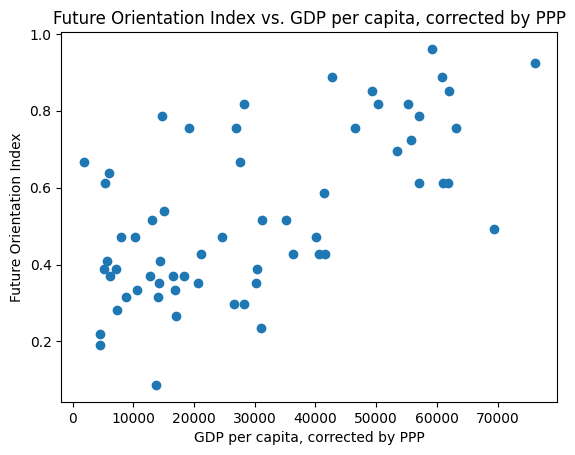

In [9]:
#Plotting

plt.plot()
plt.scatter( wdi_data["NY.GDP.PCAP.PP.KD"], wdi_data["FOI"], colorizer="cornflowerblue")
plt.ylabel("Future Orientation Index")
plt.xlabel("GDP per capita, corrected by PPP")
plt.title("Future Orientation Index vs. GDP per capita, corrected by PPP")

#### 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [10]:
# Calculating pearson's correlation coefficient
corr=stats.pearsonr(wdi_data["FOI"],wdi_data["NY.GDP.PCAP.PP.KD"]).statistic
print(f"Pearson's correlation coefficient between GDP and FOI is {corr}")

Pearson's correlation coefficient between GDP and FOI is 0.6311495785227137


### To learn more
#### Check robustness
* What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
* How do results change if you use a different threshod instead of 5 Million Internet users?
    
#### Test other hypotheses
* Is future orientation generating wealth? Or is wealth enabling to look more to the future?
* Is the FOI really measuring orientation to the future? Could it be something else?

## Part 2
## Using Google Trends data to model Flu Trends

### Install requirements. 

In [11]:
# ! pip install -U pytrends
# ! pip install requests
# ! pip install statsmodels

In [12]:
from pytrends.request import TrendReq
import requests
from datetime import datetime
import csv

### Exercise 4 *(4 points)*
Use the [pytrends module](https://pypi.org/project/pytrends/) to get weekly Google Trends data concerning the [Flu/Influenza](https://en.wikipedia.org/wiki/Influenza) virus from the beginning of 2014 until the end of 2018. 
<br>

- Create an instance of the `TrendReq` class
- Find the appropriate query term. The TrendReq class includes a method `suggestions`, which should help you in this task (the query term can look like e.g. `/m/03x_m3v`).
- Specify the correct geographical region, the timeframe, and the key-word list. Use the `build_payload` method to store this information for future requests.
- Use the `interest_over_time` method to get the data.
<br><br>

***Hint:*** *the pytrends module currently has a bug. If you get a `TooManyRequestsError` despite following the documentation, try following the advice outlined [here](https://github.com/GeneralMills/pytrends/issues/573#issuecomment-1501897119) or [here](https://github.com/GeneralMills/pytrends/issues/561#issuecomment-1462899426) (both solve the issue).*

In [13]:
# Creating cookie for the trends request
session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

In [14]:
# Accessing data using the TrendReq API
flu_pytrend=TrendReq(hl='en-US', tz=360, retries=3, requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})
flu_keywords=flu_pytrend.suggestions(keyword="Influenza")
flu_pytrend.build_payload([flu_keywords[0]["mid"]], cat=0, timeframe="2014-01-01 2018-12-31", geo="", gprop="")
flu_data=flu_pytrend.interest_over_time()
flu_data.drop(columns=["isPartial"], inplace=True)
flu_data.reset_index(inplace=True)
flu_data.to_csv('influenza_google_trends.csv', index=False)


In [15]:
#Preparing the data (i.e. creating year and week variables from the date for later merging)
flu_data=pd.read_csv("influenza_google_trends.csv")
flu_data["date"]=pd.to_datetime(flu_data["date"])
flu_data["year"]=flu_data["date"].dt.isocalendar().year
flu_data["week"]=flu_data["date"].dt.isocalendar().week

### Exercise 5 *(2 points)*

In the `a01` folder you will find a file named `ILINet.csv`, which contains data regarding the occurance of Influenza like Illnesses in the US. You can also find the data and the corresponding [documentation](https://gis.cdc.gov/grasp/fluview/FluViewPhase2QuickReferenceGuide.pdf) on the CDC's [FluView interactive dashboard](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html).
<br>
- Read the csv file, and store it as a [pandas](https://pypi.org/project/pandas/) dataframe. You might need to use the `skiprows` argument of the `read_csv` method to be able to load the data correctly.
- Select the columns named `YEAR`, `WEEK`, and `% WEIGHTED ILI` which will be needed for our analysis. Additionally, drop the rows which store observations from before 2014, or after 2018.

In [16]:
# Loading and preparing the ILINet Data
ILINet=pd.read_csv("ILINet.csv", skiprows=1)[["YEAR","WEEK","% WEIGHTED ILI"]]
ILINet = ILINet[(ILINet["YEAR"] >= 2014) & (ILINet["YEAR"] <= 2018)]
ILINet['date'] = pd.to_datetime(ILINet['YEAR'].astype(str) + ILINet['WEEK'].astype(str).str.zfill(2) + '1', format='%G%V%u')
ILINet.reset_index(inplace=True)

ILINet

,index,YEAR,WEEK,% WEIGHTED ILI,date
0,848,2014,1,4.28195,2013-12-30
1,849,2014,2,3.56288,2014-01-06
2,850,2014,3,3.36378,2014-01-13
3,851,2014,4,3.39659,2014-01-20
4,852,2014,5,3.11922,2014-01-27
...,...,...,...,...,...
256,1104,2018,48,2.14883,2018-11-26
257,1105,2018,49,2.25531,2018-12-03
258,1106,2018,50,2.64571,2018-12-10
259,1107,2018,51,3.14075,2018-12-17


### Exercise 6 *(6 points)*

Next, we will use the [statsmodels](https://www.statsmodels.org/stable/index.html) module to build some models which can predict Flu infections. 
<br>
- Create an [autoregressive model](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html) using `% WEIGHTED ILI` as a dependent variable and it's [lagged](https://ibf.org/knowledge/glossary/lagged-dependent-variable-156) versions as explanatory variables. You are free to use as many lags as possible to find the best fitting model, as measured by the [Bayesian Information Criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
- You may also add [trend](https://towardsdatascience.com/understanding-time-series-trend-addfd9d7764e) and/or [seasonal](https://towardsdatascience.com/seasonality-of-time-series-5b45b4809acd) variables to the model to improve your model's fit.
- Create another model with `% WEIGHTED ILI` as a dependent variable and the Google Trend volume from the same week as the explanatory variable.
- Last, create a model which uses both the lagged values of `% WEIGHTED ILI` and the Google Trends data (and/or its lagged versions) as explanatory variables to achieve the best fit. 
- Create a linechart showing the real values of `% WEIGHTED ILI` as well as the values predicted by all three models. Discuss your results.

In [17]:
# Building and estimating Model 1: 
## Lag-number of 2 and a constant trend minimize BIC and optimizes model's fit, seasonal flag and a 52 week period does not decrease the BIC.

model1=AutoReg(ILINet["% WEIGHTED ILI"],2, trend="c")
model1_results=model1.fit()
print(model1_results.summary())

ILINet["autoreg_predict"]=model1_results.predict()

                            AutoReg Model Results                             
Dep. Variable:         % WEIGHTED ILI   No. Observations:                  261
Model:                     AutoReg(2)   Log Likelihood                   4.999
Method:               Conditional MLE   S.D. of innovations              0.237
Date:                Mon, 28 Apr 2025   AIC                             -1.999
Time:                        16:08:43   BIC                             12.229
Sample:                             2   HQIC                             3.722
                                  261                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0844      0.026      3.218      0.001       0.033       0.136
% WEIGHTED ILI.L1     1.6069      0.048     33.679      0.000       1.513       1.700
% WEIGHTED ILI.L2    -0.

In [18]:
# Building and estimating Model 2:
ILINet=pd.merge(ILINet, flu_data, left_on=["YEAR", "WEEK"], right_on=["year","week"])

model2=AutoReg(ILINet["% WEIGHTED ILI"], exog=ILINet["/m/0cycc"],lags=0,trend="c")
model2_results=model2.fit()
print(model2_results.summary())
ILINet["trends_predict"]=model2_results.predict()

                            AutoReg Model Results                             
Dep. Variable:         % WEIGHTED ILI   No. Observations:                  260
Model:                   AutoReg-X(0)   Log Likelihood                -251.229
Method:               Conditional MLE   S.D. of innovations              0.636
Date:                Mon, 28 Apr 2025   AIC                            508.458
Time:                        16:08:43   BIC                            519.140
Sample:                             0   HQIC                           512.753
                                  260                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1251      0.073      1.702      0.089      -0.019       0.269
/m/0cycc       0.0788      0.003     29.369      0.000       0.074       0.084


In [19]:
# Building and estimating Model 3:
## Time trend improves BIC

model3=AutoReg(ILINet["% WEIGHTED ILI"],lags=2, exog=ILINet["/m/0cycc"],trend="t")
model3_results=model3.fit()
print(model3_results.summary())
ILINet["trends_autoreg_predict"]=model3_results.predict()

                            AutoReg Model Results                             
Dep. Variable:         % WEIGHTED ILI   No. Observations:                  260
Model:                   AutoReg-X(2)   Log Likelihood                   3.567
Method:               Conditional MLE   S.D. of innovations              0.239
Date:                Mon, 28 Apr 2025   AIC                              2.866
Time:                        16:08:43   BIC                             20.630
Sample:                             2   HQIC                            10.009
                                  260                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
trend                -0.0002      0.000     -1.316      0.188      -0.001       0.000
% WEIGHTED ILI.L1     1.2049      0.059     20.537      0.000       1.090       1.320
% WEIGHTED ILI.L2    -0.

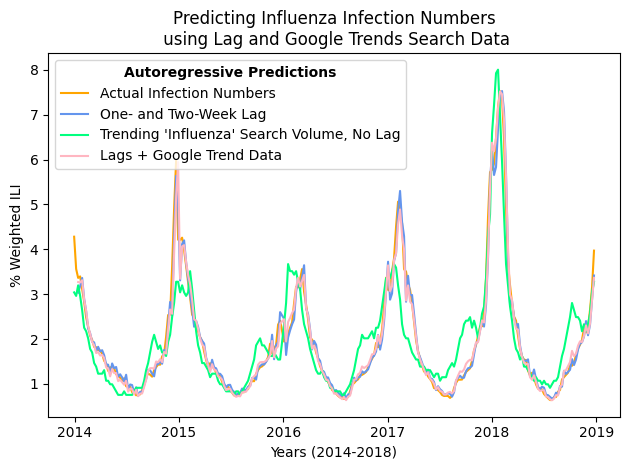

In [20]:
plt.plot()
plt.plot(ILINet["date_x"], ILINet["% WEIGHTED ILI"], color="orange", label="Actual Infection Numbers")
plt.plot(ILINet["date_x"], ILINet["autoreg_predict"], color="cornflowerblue", label="One- and Two-Week Lag")
plt.plot(ILINet["date_x"], ILINet["trends_predict"], color="springgreen", label="Trending 'Influenza' Search Volume, No Lag")
plt.plot(ILINet["date_x"], ILINet["trends_autoreg_predict"], color="lightpink", label="Lags + Google Trend Data")
legend=plt.legend(title="Autoregressive Predictions").get_title().set_fontweight("bold")
plt.title("Predicting Influenza Infection Numbers\n using Lag and Google Trends Search Data")
plt.ylabel("% Weighted ILI")
plt.xlabel("Years (2014-2018)")
plt.tight_layout()
plt.show()

#### Discussion:

The chart provides insight into the performance of the three model with respect to the actual infection development.
The best performance is provided by the autoregressive prediction using two lags (one- and two-week lag) which aligns very closely to the actual infection numbers. To a certain degree, this also holds for the combined autoregression using the lags and google trend data. However, some small divergences, for example towards the end of 2017, might suggest that the combined model suffers to some extent from overestimations induced by the trend data. This becomes more evident in the regression using only google trend data which predicts infection peaks "too early" but also regularly underestimates infection peaks during the winter months (see for example 2015 or 2017).

### To learn more
#### p-Hacking
* Try downloading data for other queries to see if you can improve the fit of your model.
    
#### Prediction
* Download the Google Trends data for 2019, and use your models to predict the values of `% WEIGHTED ILI`. Do the models make good predictions? Which model performs better?